In [1]:
import xarray as xr
import numpy as np
import xroms
import matplotlib.pyplot as plt
import sys
sys.path.append('/scratch/ss4338/2020/')
from track import track
from Interpolation import interpolation

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [78]:
import pandas as pd

In [15]:
# accessing dataset
link = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/DopAnV3R3-ini2007_da/avg"
chunk = {"ocean_time":15}
ds = xroms.open_netcdf(link, chunks=chunk)

bathymetry = ds.h

extent = [-76,-65, 34, 44]
sigma = 15
lon_left = -75
lon_right = -70.65
isobath_value = 65
track_coords = track(ds, bathymetry, extent, lon_left, lon_right, isobath_value, sigma)

# Creating Track

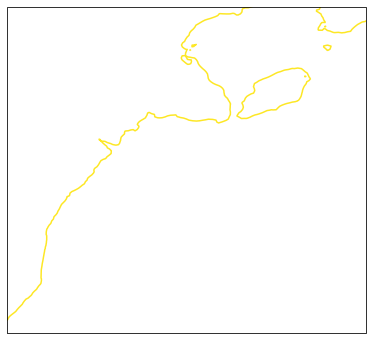

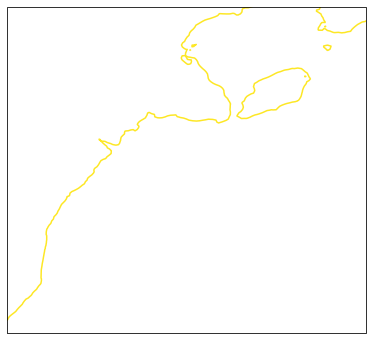

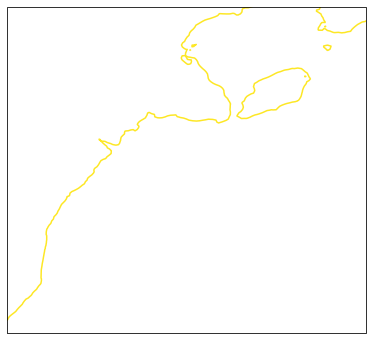

In [6]:
AB_lon_lat, AB_ij = track_coords.AB_track(-0.74,50);
CD_lon_lat, CD_ij = track_coords.CD_track( 0.32,50);
BC_lon_lat, BC_ij = track_coords.BC_track();

In [7]:
final_ij_isobath = np.vstack((AB_ij[::-1], BC_ij, CD_ij))

final_lon_lat = np.vstack((AB_lon_lat[::-1], BC_lon_lat, CD_lon_lat))

lon_lat, ij_isobath = xr.DataArray(final_lon_lat), xr.DataArray(final_ij_isobath)
lon_lat, ij_isobath = lon_lat.rename({'dim_0':'along_track','dim_1':'lon_lat'}), ij_isobath.rename({'dim_0':'along_track', 'dim_1':'i_j'}) 


# creating area mask

In [8]:
x1,y1 = AB_ij[0]
x2,y2 = AB_ij[-1]

m = (y2-y1)/(x2-x1)
y = y2-m*x2

In [9]:
x1,y2 = CD_ij[0]
x2,y2 = CD_ij[-1]

m = (y2-y1)/(x2-x1)
x = (106 - y2)/m + x2

In [10]:
vertices1 = (0, y)  
vertices2 = (x,106)


import matplotlib.path as mpath

def create_mask(shape, polygon):
    y,x = np.mgrid[:shape[0], :shape[1]]
    points = np.column_stack((x.ravel(), y.ravel()))
    path = mpath.Path(polygon)
    mask = path.contains_points(points).reshape(shape)
    
    return mask

shape = (106, 242)
polygon = np.vstack((vertices1, final_ij_isobath, vertices2))
# polygon = final_ij_isobath


mask = create_mask(shape, polygon)

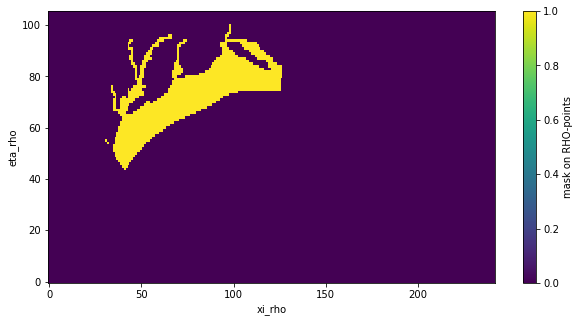

In [11]:
new_mask = (ds.mask_rho*mask)
new_mask.plot(figsize=(10,5))

# Calculation of net air-sea flux

In [11]:
sflux = ds.shflux*new_mask
area = new_mask*ds.dA
net_sheat = ((sflux.mean(dim='ocean_time'))*area).sum(dim=['eta_rho','xi_rho'])

In [13]:
Q_air_sea = net_sheat

In [14]:
Q_air_sea.values

array(2.10534384e+12)

In [113]:
# defference between annual mean calculated from daily data and annual_avg

((2.07793128e+12 - 2.18307392e+12)/2.18307392e+12)*100

-4.816265681008181

In [17]:
θ = 2

In [22]:
asflux = (sflux*new_mask).resample(ocean_time='Y').mean(dim='ocean_time')

In [25]:
time_series_aflux = (asflux*area).sum(dim=['eta_rho','xi_rho'])

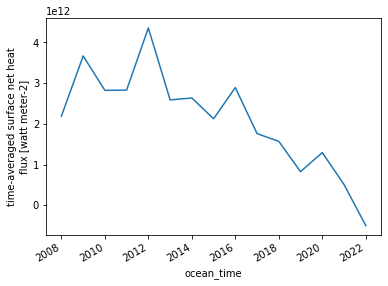

In [26]:
time_series_aflux.plot()

### decrease in net annual air-sea heat transfer from 2007 to 2020 year

In [27]:
1.27640918e+12-2.18214323e+12

-905734050000.0

In [29]:
((1.27640918e+12-2.18214323e+12)/2.18214323e+12)*100

-41.5066269504225

### difference between history file data and year_avg file data

In [35]:
# year_avg - his

2.07793128e+12-2.18214323e+12, ((-2.07793128e+12+2.18214323e+12)/2.07793128e+12)*100

(-104211950000.0, 5.01517788403474)

# Calculation of advective heat transport

In [16]:
# start = '2007'
# end = '2007-12-31'
# ds = ds.sel(ocean_time=slice(start,end))
#creating track class instance to feed it in different class and creating interpolation instance
track_instance = track_coords 
interpol = interpolation(ds, lon_lat, ij_isobath[:,0], ij_isobath[:,1], track_instance);

# interpolating temperature and velocity
# temp = interpol.temperature();
# nvel, pvel = interpol.velocity();


In [13]:
temp = temp.mean(dim='ocean_time')
nvel = nvel.mean(dim='ocean_time')

In [70]:
temp = temp.sortby('s_rho')
temp = temp.sortby('along_track')

### velocity correction calculation

In [17]:
%%time

dz = interpol.dz() # difference between .dz() and .dz?

dS = xr.DataArray(interpol.delta_s(lon_lat), dims=['along_track'])

dz = dz.mean(dim='ocean_time')

vol = ((ds.dV*new_mask).mean(dim='ocean_time')).sum()

CPU times: user 146 ms, sys: 4.46 ms, total: 150 ms
Wall time: 146 ms


In [57]:
vel_corr = (nvel*dz*dS).sum()/(dz*dS).sum()

vel_corr.values

array(2.07153197)

In [73]:
(((nvel-vel_corr)*dz*dS).sum()).values

array(-2.18278728e-11)

In [66]:
new_nvel = nvel-vel_corr

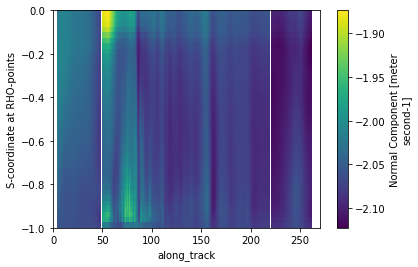

In [68]:
new_nvel.plot()

### calculate volumetric temperature

In [59]:
volume = ((ds.dV.isel(ocean_time=0))*new_mask)
VT_1 = ((ds.temp.isel(ocean_time=0))*new_mask)

VT_1 = (VT_1*volume).sum()/volume.sum()
# VT_1.values

In [60]:
volume = ((ds.dV.isel(ocean_time=-1))*new_mask)
VT_2 = ((ds.temp.isel(ocean_time=-1))*new_mask)

VT_2 = (VT_2*volume).sum()/volume.sum()
# VT_2.values

In [61]:
VT_2.values - VT_1.values

-3.361657812027735

In [111]:
mean_T = (ds.temp*new_mask).mean(dim='ocean_time')
volume = (ds.dV*new_mask).mean(dim='ocean_time')

In [112]:
%%time
# for entire 15 years
vol = ((ds.dV*new_mask).mean(dim='ocean_time')).sum()
T_vol = (mean_T*volume).sum()/vol

T_vol.values

CPU times: user 6min 57s, sys: 3min 46s, total: 10min 44s
Wall time: 18min 2s


array(12.47696981)

In [63]:
# for year 2007 only
T_vol = (mean_T*volume).sum()/vol

T_vol.values

array(11.88659665)

In [93]:
T_vol_2008 = (ds.temp*ds.dV*new_mask).sum()/vol

T_vol_2008.values

array(11.68145069)

In [65]:
temp = temp.mean(dim='ocean_time')
nvel = nvel.mean(dim='ocean_time')


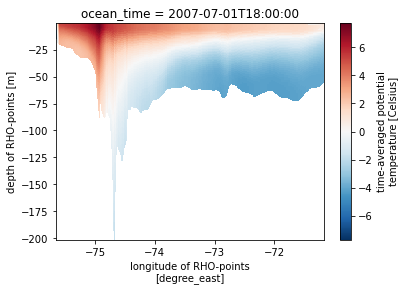

In [83]:
(temp-T_vol).cf.plot()

In [28]:
rho, cp = 1025, 3985 # volumetric heat capacity
Q_advective = (rho*cp*(-new_nvel)*(temp-T_vol)*dz*dS).sum()
Q_advective.values

array(-4.10976818e+12)

In [72]:
%%time
rho, cp = 1025, 3985 # volumetric heat capacity
Q_advective = (rho*cp*(-new_nvel)*(temp-T_vol)*dz*dS).sum()
Q_advective.values

CPU times: user 1min 29s, sys: 45.4 s, total: 2min 15s
Wall time: 4min 28s


array(-1.50331538e+14)

# Calculation of heat transport due to monthly variability

In [40]:
# ((v-star*temp-star)dz*dz).sum()

U_star = nvel.resample(ocean_time='M').mean(dim='ocean_time') - (nvel.resample(ocean_time='Y').mean(dim='ocean_time')).values
temp_star = temp.resample(ocean_time='M').mean(dim='ocean_time') - (temp.resample(ocean_time='Y').mean(dim='ocean_time')).values

In [44]:
rho, cp = 1025, 3985
heat_transport_monthly = (rho*cp*((U_star*temp_star).mean(dim='ocean_time'))*dz*dS).sum()

In [47]:
%%time
heat_transport_monthly.values

CPU times: user 1min 32s, sys: 52.7 s, total: 2min 24s
Wall time: 5min 37s


array(-9.06363249e+11)

# Calculating heat transport due to eddy flux

In [52]:
# ((v-star*temp-star)dz*dz).sum()
U_m = nvel.resample(ocean_time='M').mean(dim='ocean_time')
T_m = temp.resample(ocean_time ='M').mean(dim='ocean_time')

U_dash = nvel.groupby('ocean_time.month').map(lambda x: 
                                                 x - U_m.isel(ocean_time=x['ocean_time.month'][0]-1))
temp_dash = temp.groupby('ocean_time.month').map(lambda x: 
                                                 x - T_m.isel(ocean_time=x['ocean_time.month'][0]-1))

In [54]:
heat_transport_eddy = (rho*cp*((U_dash*temp_dash).mean(dim='ocean_time'))*dz*dS).sum()

In [56]:
%%time
heat_transport_eddy.values


CPU times: user 1min 6s, sys: 34.2 s, total: 1min 40s
Wall time: 3min 46s


array(-2.468643e+11)

### positive flux means heat going inside, heating and vice-versa

# Balance check

In [29]:
(((Q_air_sea + Q_advective)*(60*60*24*365))/(rho*cp*vol)).values

array(-6.24365267)

In [73]:
Q_air_sea = 2.183074e+12
Q_mean = -4.10976818e+12
Q_monthly = 9.06363249e+11
Q_eddy = 2.468643e+11

In [74]:
(((Q_air_sea + Q_mean + Q_monthly + Q_eddy )*(60*60*24*365))/(rho*cp*vol)).values

array(-3.20320925)

In [75]:
VT_2.values - VT_1.values

-3.361657812027735

In [77]:
((3.20320925 - 3.361657812027735)/(- 3.361657812027735))*100

4.713405435283122

In [30]:
import pandas as pd
data = [[-4.1765779e+12, 2.07793128e+12, 0.00557313, 11.84998687, -6.80109962], [-4.10976818e+12,2.18307392e+12, 0.00562824, 11.8780863, -6.24365267]]
pd.DataFrame(data, columns=['Advective heat', 'air-sea heat', 'velocity_corr', 'volumetric temp', 'delta T'], index=['2007','2007_avg'])

,Advective heat,air-sea heat,velocity_corr,volumetric temp,delta T
2007,-4.176578e+12,2.077931e+12,0.005573,11.849987,-6.801100
2007_avg,-4.109768e+12,2.183074e+12,0.005628,11.878086,-6.243653


In [22]:
6.24365267-3.3706932782247687

2.8729593917752316

In [2]:

daily_data = xr.open_dataset('./daily_data.nc')

temp = daily_data.temp
nvel = daily_data.normal_vel

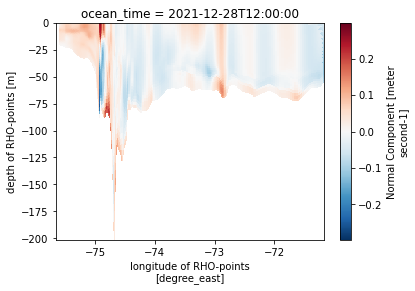

In [4]:
nvel.isel(ocean_time=-1).cf.plot()

In [100]:
V_bar = nvel.mean(dim='ocean_time')

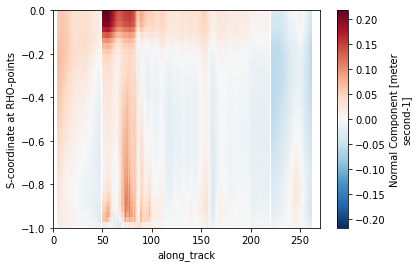

In [103]:
V_bar.plot()

In [107]:
(((V_bar*dz*dS).sum())/(dz*dS).sum()).values

array(0.00506708)

In [ ]:
%%time
rho, cp = 1025, 3985 # volumetric heat capacity
Q_advective = (rho*cp*(-new_nvel)*(temp-T_vol)*dz*dS).sum()
Q_advective.values

In [21]:
%%time
# net heat transport due to annual component 
rho, cp = 1025, 3985
U_bar = nvel.mean(dim='ocean_time') 
T_bar = temp.mean(dim='ocean_time')
U_corr = 0.00506708
T_vol = 12.47696981
new_nvel = U_bar - U_corr
new_temp = T_bar - T_vol
Q_mean = (rho*cp*(-new_nvel)*new_temp*dz*dS).sum()
Q_mean.values

CPU times: user 49.3 s, sys: 47.8 s, total: 1min 37s
Wall time: 57.9 s


array(-4.40031348e+12)

In [23]:
Temp = temp - T_vol
Vel = nvel - U_corr

In [139]:
%%time
# net heat transport due to intersnnual compponent

U_bar = Vel.mean(dim='ocean_time') 
T_bar = Temp.mean(dim='ocean_time')
Ua = Vel.resample(ocean_time='Y').mean(dim='ocean_time')
Ta = Temp.resample(ocean_time='Y').mean(dim='ocean_time')


U_ddash = Ua - U_bar.values
T_ddash = Ta - T_bar.values

Q_interannual = (rho*cp*(((-U_ddash)*T_ddash).mean(dim='ocean_time'))*dz*dS).sum()
Q_interannual.values

CPU times: user 49.1 s, sys: 44.2 s, total: 1min 33s
Wall time: 1min


array(8.37504138e+10)

In [26]:
%%time
# net heat transfer due to mean component

U_bar = Vel.mean(dim='ocean_time') 
T_bar = Temp.mean(dim='ocean_time')

Q_mean = (rho*cp*(-U_bar)*T_bar*dz*dS).sum()
Q_mean.values

CPU times: user 49.7 s, sys: 45.8 s, total: 1min 35s
Wall time: 57.3 s


array(-4.40031348e+12)

In [88]:
%%time
# net heat transport due to monthly variability

Ua = Vel.resample(ocean_time='Y').mean(dim='ocean_time')
Ta = Temp.resample(ocean_time='Y').mean(dim='ocean_time')

Um = Vel.resample(ocean_time='M').mean(dim='ocean_time')
Tm = Temp.resample(ocean_time='M').mean(dim='ocean_time')


# U_star = Um.groupby('ocean_time.year').apply(lambda x: x - Ua.sel(ocean_time=pd.to_datetime(x.ocean_time.dt.year))) #gives keyerror
# U_star = Um.groupby('ocean_time.year').apply(lambda x: x - Ua.sel(ocean_time=pd.Timestamp(year=x.ocean_time.dt.year, month=12, day=31)))
# T_star = Tm.groupby('ocean_time.year').apply(lambda x: x - Ta.sel(ocean_time=pd.Timestamp(year=x.ocean_time.dt.year, month=12, day=31)))


# Q_monthly = (rho*cp*(-U_star)*T_star*dz*dS).sum()
# Q_monthly.values




CPU times: user 1.03 s, sys: 2.1 ms, total: 1.03 s
Wall time: 1.03 s


In [116]:
U_mon = []
for i in np.arange(len(Um)):
    um = Um[i] - Ua.sel(ocean_time = pd.Timestamp(year=Um[i].ocean_time.dt.year, month=12, day=31)).values
    U_mon.append(um)



/tmp/ipykernel_32828/4181685983.py:3: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  um = Um[i] - Ua.sel(ocean_time = pd.Timestamp(year=Um[i].ocean_time.dt.year, month=12, day=31)).values


In [119]:
U_star = xr.concat(U_mon, dim='ocean_time')

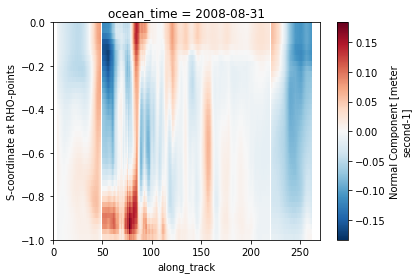

In [122]:
U_star.isel(ocean_time=19).plot()

In [135]:
T_mon = []
for i in np.arange(len(Tm)):
    tm = Tm[i] - Ta.sel(ocean_time = pd.Timestamp(year=Tm[i].ocean_time.dt.year, month=12, day=31)).values
    T_mon.append(tm)

T_star = xr.concat(T_mon, dim='ocean_time')


/tmp/ipykernel_32828/1264162487.py:3: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  tm = Tm[i] - Ta.sel(ocean_time = pd.Timestamp(year=Tm[i].ocean_time.dt.year, month=12, day=31)).values


In [138]:
%%time
# net heat transport due to monthly variability

Ua = Vel.resample(ocean_time='Y').mean(dim='ocean_time')
Ta = Temp.resample(ocean_time='Y').mean(dim='ocean_time')

Um = Vel.resample(ocean_time='M').mean(dim='ocean_time')
Tm = Temp.resample(ocean_time='M').mean(dim='ocean_time')


Q_monthly = (rho*cp*(((-U_star)*T_star).mean(dim='ocean_time'))*dz*dS).sum()
Q_monthly.values

CPU times: user 49.9 s, sys: 43.9 s, total: 1min 33s
Wall time: 57.8 s


array(5.96868513e+11)

In [153]:
%%time
# net heat transport due to eddy variability
U = Vel
T = Temp

Um = Vel.resample(ocean_time='M').mean(dim='ocean_time')
Tm = Temp.resample(ocean_time='M').mean(dim='ocean_time')

U_eddy = []

for i in np.arange(len(U)):
    u = U[i] - Um.sel(ocean_time = pd.Timestamp(year=U[i].ocean_time.dt.year, month=U[i].ocean_time.dt.month, day=15), method='nearest').values
    U_eddy.append(u)
    
U_dash = xr.concat(U_eddy, dim='ocean_time')

T_eddy = []
for i in np.arange(len(Tm)):
    t = T[i] - Tm.sel(ocean_time = pd.Timestamp(year=T[i].ocean_time.dt.year, month=T[i].ocean_time.dt.month, day=15), method='nearest').values
    T_eddy.append(t)

T_dash = xr.concat(T_eddy, dim='ocean_time')

Q_eddy = (rho*cp*(((-U_dash)*T_dash).mean(dim='ocean_time'))*dz*dS).sum()
Q_eddy.values

<timed exec>:11: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
<timed exec>:18: DeprecationWarning: an integer is required (got type DataArray).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.


CPU times: user 1min 36s, sys: 46.8 s, total: 2min 23s
Wall time: 1min 46s


array(2.90033642e+11)

In [154]:
2.10534384e+12 + (-4.40031348e+12) + 5.96868513e+11 + 2.90033642e+11 + 8.37504138e+10

-1324317071200.0

In [158]:
volume = ((ds.dV.isel(ocean_time=-1))*new_mask)
VT_2 = ((ds.temp.isel(ocean_time=-1))*new_mask)

VT_2 = (VT_2*volume).sum()/volume.sum()

In [160]:
VT_2.values

array(12.43600121)

In [161]:
volume = ((ds.dV.isel(ocean_time=0))*new_mask)
VT_1 = ((ds.temp.isel(ocean_time=0))*new_mask)

VT_1 = (VT_1*volume).sum()/volume.sum()

In [163]:
VT_1.values

array(12.15178564)